# Прогнозирование оттока клиентов от мобильного оператора

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.
То есть перед нами стоит задача бинарной классификации где действующий контракт имеет значение признака 0, а закрытые - 1.
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

В нашем распоряжении 4 таблицы:
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

## Исследование данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from catboost import cv

RANDOM_STATE = 261222

In [2]:
try:
    contract = pd.read_csv('C:/Users/Xiaomi/Desktop/Oleg/Docs/Практикум/16 спринт Финальный/final_provider/contract.csv')
    internet = pd.read_csv('C:/Users/Xiaomi/Desktop/Oleg/Docs/Практикум/16 спринт Финальный/final_provider/internet.csv')
    personal = pd.read_csv('C:/Users/Xiaomi/Desktop/Oleg/Docs/Практикум/16 спринт Финальный/final_provider/personal.csv')
    phone = pd.read_csv('C:/Users/Xiaomi/Desktop/Oleg/Docs/Практикум/16 спринт Финальный/final_provider/phone.csv')
    
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
def show_details(data):
    return data.info(), display(data.head(5)), display(data.describe())

In [4]:
show_details(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


(None, None, None)

In [5]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [6]:
contract['is_closed'] = contract['EndDate'].replace('No', 0)

In [7]:
for i in range(len(contract['EndDate'])):
    if contract.loc[i, 'is_closed'] != 0:
        contract.loc[i, 'is_closed'] = 1

In [8]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_closed
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


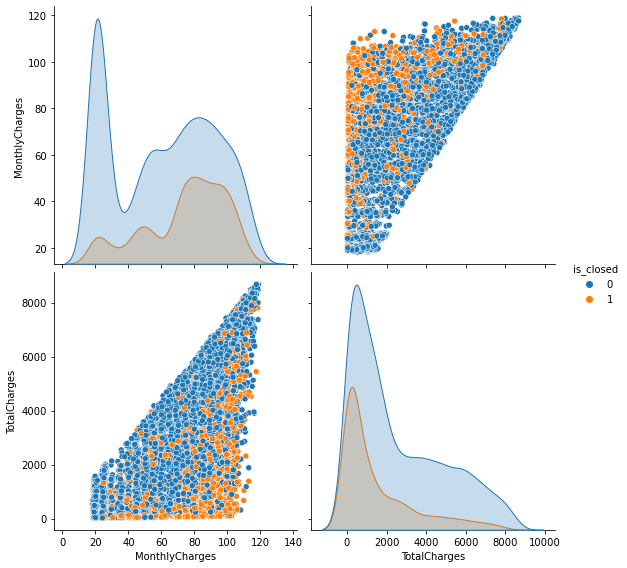

In [9]:
#посмотрим, как численные признаки связаны с таргетом
sns.pairplot(contract, hue='is_closed', height=4);

In [10]:
show_details(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


(None, None, None)

In [11]:
show_details(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


(None, None, None)

In [12]:
show_details(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


(None, None, None)

Наш целевой признак - столбец EndDate в таблице contract. Для выполнения задачи наиболее корректно было бы оценить поведение ушедших клиентов за некоторый период перед разрывом контракта. Но т.к. такой подробной информации нет, упростим задачу, и просто разделим клиентов на ушедших и действующих.

## План работы

Мы имеем задачу бинарной классификации, где нужно найти и обобщить общие паттерны у клиентов, которые прекратили свой контракт с оператором связи, чтобы далее по этим паттернам распознавать клиентов, которые собираются закрыть контракт.

План работы:

1. Объединить 4 таблицы в одну по столбцу customerID, т.к. он уникален и есть во всех таблицах.
2. Выполнить предобработку данных, обработать пропуски.
3. В целевом признаке customer['EndDate'] заменить "No" на 0, а все остальные значения на 1.
4. Добавить признак duration = EndDate - BeginDate (end для действующих - 01.02.2020)
5. Посмотреть корреляции между признаками, отфильтровать лишние
6. Разделить выборку на train, test.
7. Закодировать категориальные признаки методом OHE. Масштабировать, если понадобится.
8. Обучить несколько моделей и выбрать лучшую по результатам кросс-валидации.\
    Главная метрика для оценки моделей - AUC-ROC, вспомогательные Accuracy, F1_score.\
    Цель - AUC-ROC минимум 0.75, в идеале более 0.85 (совсем в идеале более 0.88)
9. Протестировать лучшую модель.
10. Описать выводы, написать отчет.

## Предобработка данных

In [13]:
#объединим данные в одну таблицу
data = contract.merge(personal, on='customerID', how='outer')
data = data.merge(internet, on='customerID', how='outer')
data = data.merge(phone, on='customerID', how='outer')

In [14]:
show_details(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   is_closed         7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_closed,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2283.300441,0.162147
std,30.090047,2266.771362,0.368612
min,18.250000,18.800000,0.000000
25%,35.500000,401.450000,0.000000
50%,70.350000,1397.475000,0.000000
75%,89.850000,3794.737500,0.000000
max,118.750000,8684.800000,1.000000


(None, None, None)

В таблице ожидаемо появились пропуски, которые необходимо обработать.
Также необходимо преобразовать тип данных в некоторых из признаков.

In [15]:
#заменим No в столбце EndDate на дату выгрузки информации
data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')

#преобразование типов данных
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')
data['is_closed'] = data['is_closed'].astype('int32')
data['SeniorCitizen'] = data['SeniorCitizen'].astype('int32')

#добавляем столбец с длительностью контракта
data['duration'] = data['EndDate'] - data['BeginDate']
data['duration'] = (data['duration'] / np.timedelta64(1, 'D')).astype(int)

#заменим Yes/No в соответствущих столбцах на 1/0
data['PaperlessBilling'] = data['PaperlessBilling'].replace('No', 0)
data['PaperlessBilling'] = data['PaperlessBilling'].replace('Yes', 1)
data['PaperlessBilling'] = data['PaperlessBilling'].astype('int32')

In [16]:
print('Действующих клиентов:', data.loc[data['is_closed'] == 0]['is_closed'].count())
print('Ушедших клиентов:', data.loc[data['is_closed'] == 1]['is_closed'].count())

Действующих клиентов: 5174
Ушедших клиентов: 1869


Есть дисбаланс классов примерно в соотношении 1/3

### Обработка пропусков

In [17]:
data.loc[data['TotalCharges'].isna() == True].head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_closed,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,NaN,0,Female,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,NaN,0,Male,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,NaN,0,Female,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0


In [18]:
#пропуски в столбце TotalCharges возникли у клиентов, только подключенных на момент выгрузки данных.
#Заполним их нулем
data['TotalCharges'] = data['TotalCharges'].fillna(0)

In [19]:
data.loc[data['InternetService'].isna() == True].head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_closed,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
11,7469-LKBCI,2018-10-01,2020-02-01,Two year,0,Credit card (automatic),18.95,326.80,0,Male,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,488
16,8191-XWSZG,2015-10-01,2020-02-01,One year,0,Mailed check,20.65,1022.95,0,Female,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1584
21,1680-VDCWW,2019-02-01,2020-02-01,One year,0,Bank transfer (automatic),19.80,202.25,0,Male,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,365


Пропуски в столбцах с услугами возникли из-за объединения таблиц - кто-то пользуется только телефоном, кто-то интернетом, кто-то и тем и тем. Эти пропуски логично заполнить 'No'.

In [20]:
data['InternetService'] = data['InternetService'].fillna('No')
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('No')
data['OnlineBackup'] = data['OnlineBackup'].fillna('No')
data['DeviceProtection'] = data['DeviceProtection'].fillna('No')
data['TechSupport'] = data['TechSupport'].fillna('No')
data['StreamingTV'] = data['StreamingTV'].fillna('No')
data['StreamingMovies'] = data['StreamingMovies'].fillna('No')
data['MultipleLines'] = data['MultipleLines'].fillna('No')

In [21]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_closed,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,No,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,No,Fiber optic,No,No,No,No,No,No,No,61


In [22]:
#заменим Yes/No на 1/0 в категориальных признаках
services = ['OnlineSecurity',
            'OnlineBackup',
            'DeviceProtection',
            'TechSupport',
            'StreamingTV',
            'StreamingMovies',
            'MultipleLines']

status = ['Partner', 'Dependents']

data[services] = data[services].replace('Yes', 1)
data[services] = data[services].replace('No', 0)

data[status] = data[status].replace('Yes', 1)
data[status] = data[status].replace('No', 0)

In [23]:
#создадим признак "количество услуг", возможно он пригодится в обучении
data['services_amount'] = (
    data['OnlineSecurity'] +
    data['OnlineBackup'] +
    data['DeviceProtection'] +
    data['TechSupport'] +
    data['StreamingTV'] +
    data['StreamingMovies'] +
    data['MultipleLines']
)

### Исследование очищенных данных

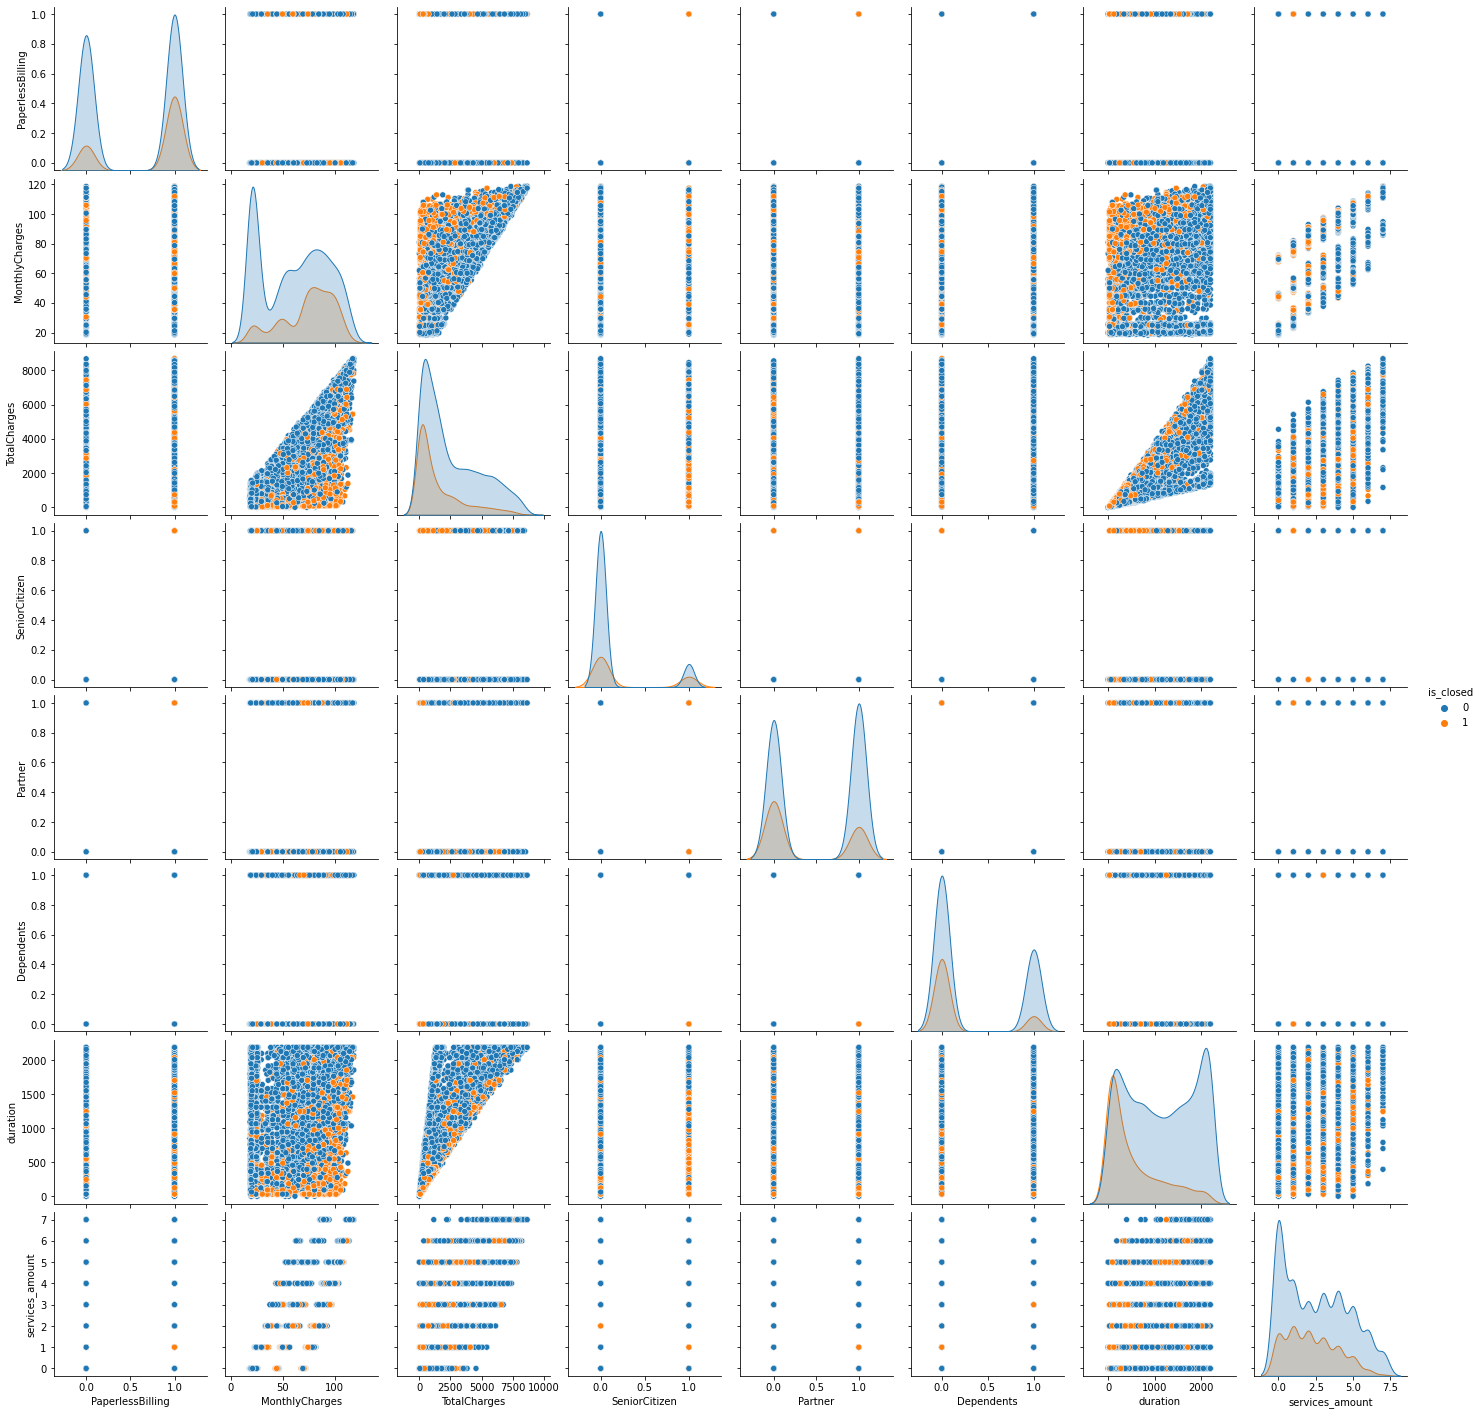

In [24]:
#визуализируем очищенный датасет
sns.pairplot(data.drop(services, axis=1), hue='is_closed');

На обновленном графике уже можно увидеть связи некоторых признаков с таргетом. В частности новые клиенты (с низким duration) уходят намного чаще старых. Можно увидеть связь таргета с  параметром MonthlyCharges - чем выше этот показатель, тем чаще пользователи перестают пользоваться услугами оператора.

Я добавил признак service_amount, т.к. имел гипотезу, что кол-во подключенных сервисов влияет на уход/не уход клиента. Судя по графику, гипотеза скорее не подтвердилась - "отказники" почти равномерно размазаны по диаграмме этого признака.

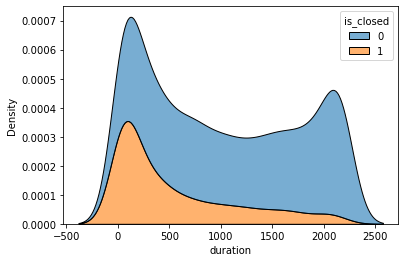

In [25]:
#связь длительности контракта с таргетом
sns.kdeplot(data=data, x='duration', hue='is_closed', multiple='stack', alpha=.6);

Большинство "отказников" закрывает контракт вскоре после его открытия. Следует внимательнее изучить поведение новых клиентов в первые недели после подписания контракта - что-то отталкивает клиентов именно в этот период. С ростом длительности пользования количество "отказников" стабильно снижается.

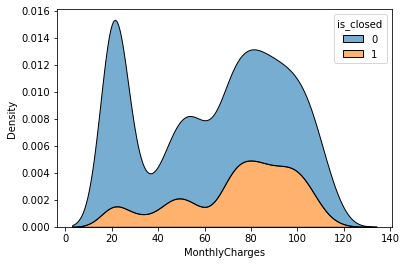

In [26]:
#связь ежемесячного платежа с таргетом
sns.kdeplot(data=data, x='MonthlyCharges', hue='is_closed', multiple='stack', alpha=.6);

Пик уходящих клиентов приходится на показатель около 80, действующих - на 20. Вывод из этого графика можно описать как "чем меньше платит клиент, тем меньше вероятность его ухода". 

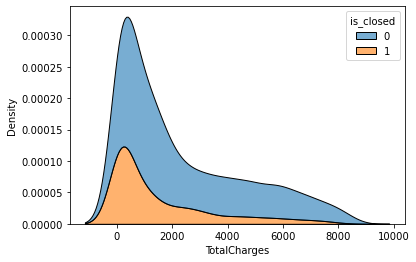

In [27]:
#связь общей суммы контракта с таргетом
sns.kdeplot(data=data, x='TotalCharges', hue='is_closed', multiple='stack', alpha=.6);

Здесь 2 распределения очень близки друг с другом, за тем исключением, что клиенты с накопительной суммой платежа более 8000 почти не уходят. Что еще раз подтверждает гипотезу, что новые клиенты уходят гораздо чаще, чем старые.

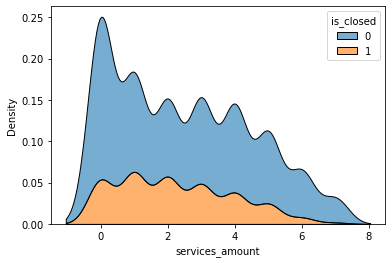

In [28]:
#связь количества сервисов с таргетом
sns.kdeplot(data=data, x='services_amount', hue='is_closed', multiple='stack', alpha=.6);

Связь синтетического признака "количество подключенных сервисов" с таргетом если и есть, то минимальная, т.к. 2 распределения почти идентичны. Отвергнутая гипотеза - это тоже результат, теперь мы знаем, что количество услуг не влияет на решение клиента об уходе.

### Корреляции данных

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'is_closed', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'duration', 'services_amount']
interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'is_closed', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'duration', 'services_amount']
interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'is_closed', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'duration', 'services_amount']


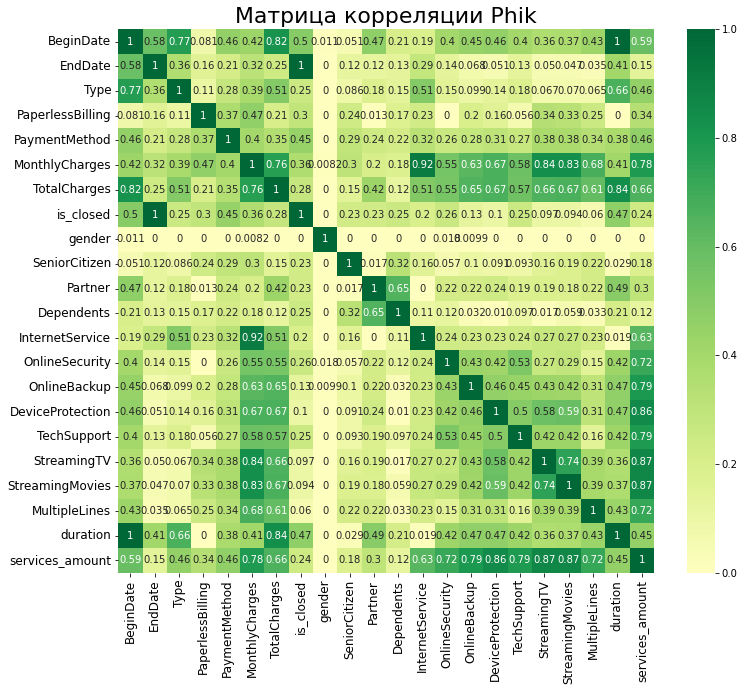

In [29]:
# оценка корреляции по коэффициенту phi
data_no_ID = data.drop('customerID', axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(data_no_ID.phik_matrix(),
            xticklabels=data_no_ID.phik_matrix().columns,
            yticklabels=data_no_ID.phik_matrix().columns,
            cmap='RdYlGn', center=0, annot=True)
plt.title('Матрица корреляции Phik', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Идеальная связь между таргетом (is_closed) и EndDate неудивительна, т.к. таргет - это производное от столбца EndDate. Значительно коррелируют с таргетом данные в столбцах duration, PaymentMethod, MonthlyCharges. Остальные связи между признками и таргетом слабые и/или неочевидные. Пока что оставим все признаки в датасете, а решение об удалении тех или иных признаков примем после оценки важности признаков для обучения.

## Разделение выборки на train \ test

In [30]:
train, test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE, stratify=data['is_closed'])

In [31]:
train.shape

(5282, 23)

In [32]:
test.shape

(1761, 23)

In [33]:
train.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_closed,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,services_amount
937,6400-BWQKW,2019-04-01,2019-10-01,Month-to-month,1,Electronic check,79.05,434.50,1,Female,...,Fiber optic,1,0,0,0,0,0,1,183,2
2082,3486-KHMLI,2018-05-01,2020-02-01,Month-to-month,0,Mailed check,24.70,467.15,0,Male,...,No,0,0,0,0,0,0,1,641,1
5495,2696-NARTR,2018-12-01,2019-11-01,Month-to-month,1,Electronic check,73.85,926.25,1,Male,...,Fiber optic,0,0,0,1,0,0,0,335,1
4090,1453-RZFON,2020-01-01,2020-02-01,Month-to-month,0,Mailed check,49.90,49.90,0,Female,...,DSL,1,0,0,0,0,0,0,31,1
2706,7598-UAASY,2019-11-01,2020-01-01,Month-to-month,0,Electronic check,76.40,151.80,1,Male,...,Fiber optic,0,0,1,0,0,0,0,61,1


In [34]:
#уберем "лишниие" для обучения признаки
train = train.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)
test = test.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 937 to 4829
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   int32  
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   TotalCharges      5282 non-null   float64
 5   is_closed         5282 non-null   int32  
 6   gender            5282 non-null   object 
 7   SeniorCitizen     5282 non-null   int32  
 8   Partner           5282 non-null   int64  
 9   Dependents        5282 non-null   int64  
 10  InternetService   5282 non-null   object 
 11  OnlineSecurity    5282 non-null   int64  
 12  OnlineBackup      5282 non-null   int64  
 13  DeviceProtection  5282 non-null   int64  
 14  TechSupport       5282 non-null   int64  
 15  StreamingTV       5282 non-null   int64  
 16  StreamingMovies   5282 non-null   int64 

In [36]:
#выбираем категориальные признаки для кодирования
ohe_features_ridge = train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

['Type', 'PaymentMethod', 'gender', 'InternetService']


In [37]:
train_ohe = train.copy()
test_ohe = test.copy()

In [38]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder_ohe.fit(train_ohe[ohe_features_ridge])
train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(train_ohe[ohe_features_ridge])
train_ohe = train_ohe.drop(ohe_features_ridge, axis=1)

In [39]:
train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 937 to 4829
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   PaperlessBilling                         5282 non-null   int32  
 1   MonthlyCharges                           5282 non-null   float64
 2   TotalCharges                             5282 non-null   float64
 3   is_closed                                5282 non-null   int32  
 4   SeniorCitizen                            5282 non-null   int32  
 5   Partner                                  5282 non-null   int64  
 6   Dependents                               5282 non-null   int64  
 7   OnlineSecurity                           5282 non-null   int64  
 8   OnlineBackup                             5282 non-null   int64  
 9   DeviceProtection                         5282 non-null   int64  
 10  TechSupport                              5282 

In [40]:
#аналогично кодируем признаки тестовой выборки
test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(test_ohe[ohe_features_ridge])
test_ohe = test_ohe.drop(ohe_features_ridge, axis=1)

In [41]:
features_ohe_train = train_ohe.drop('is_closed', axis=1)
target_ohe_train = train_ohe['is_closed']
features_ohe_test = test_ohe.drop('is_closed', axis=1)
target_ohe_test = test_ohe['is_closed']

## Обучение

### DecisionTree

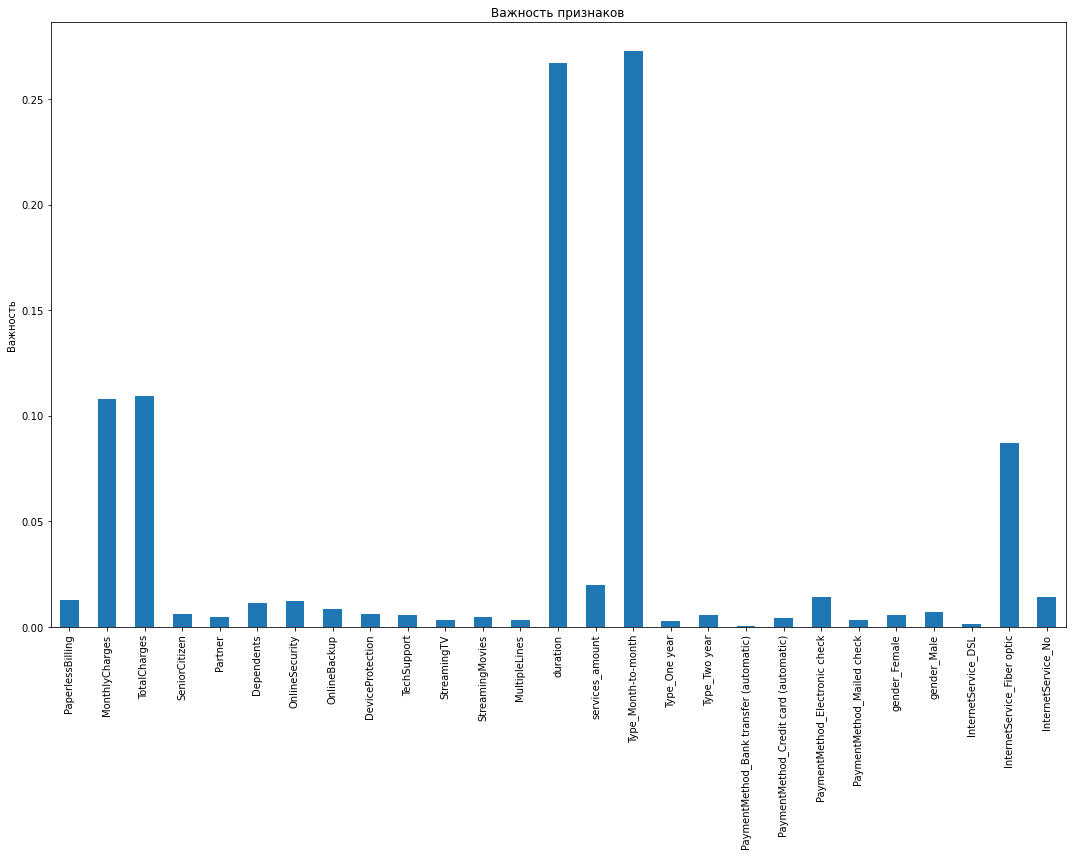

In [42]:
#оценка важности признаков
model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=10)
model.fit(features_ohe_train, target_ohe_train)
tree_imp = pd.Series(model.feature_importances_, features_ohe_train.columns)
fig, ax = plt.subplots(figsize=(15, 12))
tree_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

In [43]:
#обучим модель, отобрав только наиболее важные признаки
features_imp_train = features_ohe_train[['MonthlyCharges', 
                                         'TotalCharges', 
                                         'duration', 
                                         'Type_Month-to-month', 
                                         'InternetService_Fiber optic']]

best_depth = 0
score_tree = 0
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    scores = cross_val_score(model, features_ohe_train, target_ohe_train, scoring='roc_auc', cv=5)
    if scores.mean() > score_tree:
        score_tree = scores.mean()
        best_depth = depth

print('Лучший результат roc_auc:', score_tree)
print('Лучшая глубина:', best_depth)

Лучший результат roc_auc: 0.8393974025021095
Лучшая глубина: 5


### RandomForestClassifier

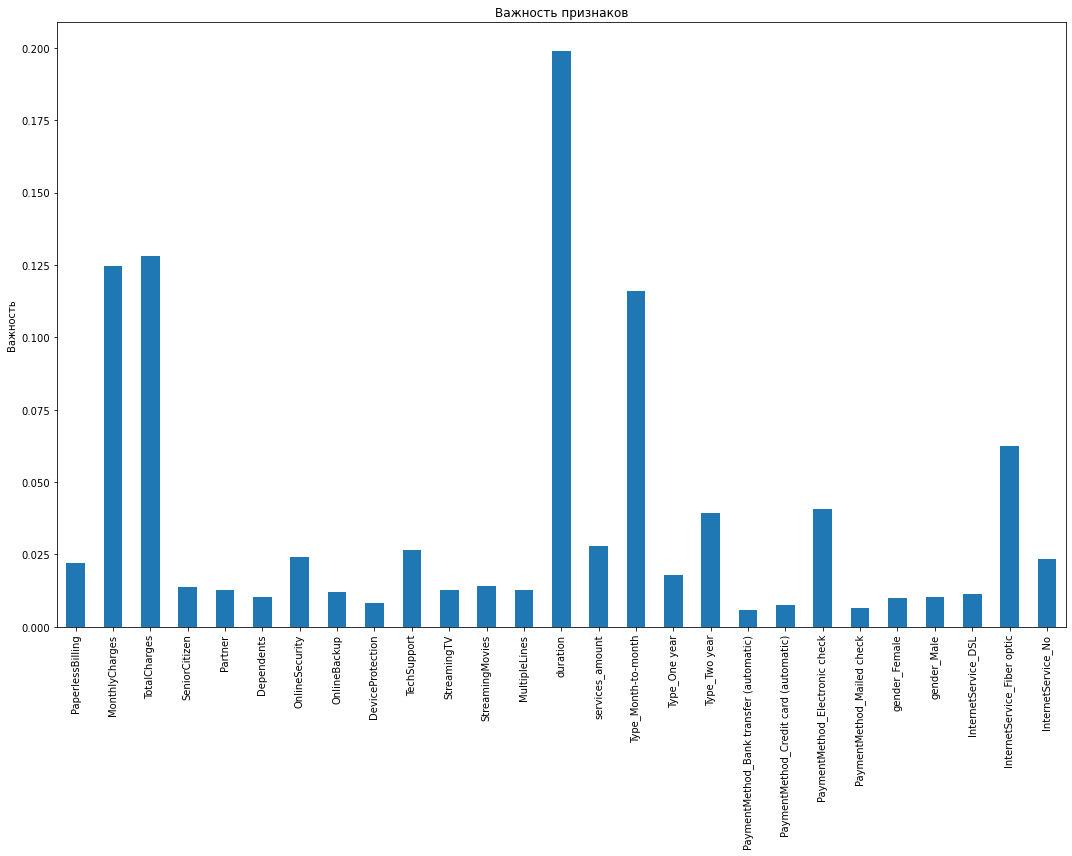

In [44]:
#оценка важности признаков
model = RandomForestClassifier(random_state=RANDOM_STATE,
                               n_estimators=30, 
                               max_depth=11, 
                               min_samples_leaf=3, 
                               min_samples_split=8)
model.fit(features_ohe_train, target_ohe_train)
rf_imp = pd.Series(model.feature_importances_, features_ohe_train.columns)
fig, ax = plt.subplots(figsize=(15, 12))
rf_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

In [45]:
%%time

#подбор оптимальных гиперпараметров

features_imp_train = features_ohe_train[['MonthlyCharges', 
                                         'TotalCharges', 
                                         'duration', 
                                         'Type_Month-to-month',
                                         'Type_Two year',
                                         'PaymentMethod_Electronic check',
                                         'InternetService_Fiber optic']]

clf = RandomForestClassifier(random_state=RANDOM_STATE)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 13, 2),
              'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2, 10, 2) }

grid = GridSearchCV(clf, parametrs, scoring='roc_auc', cv=5)
grid.fit(features_imp_train, target_ohe_train)
grid.best_params_

CPU times: total: 4min 52s
Wall time: 4min 57s


{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 40}

Зафиксируем гиперпараметры лучшей модели, полученные алгоритмом GridSearch:
n_estimators=40, max_depth=7, min_samples_leaf=1, min_samples_split=4

In [46]:
#кросс-валидация и проверка метрики
features_imp_train = features_ohe_train[['MonthlyCharges', 
                                         'TotalCharges', 
                                         'duration', 
                                         'Type_Month-to-month',
                                         'Type_Two year',
                                         'PaymentMethod_Electronic check',
                                         'InternetService_Fiber optic']]
model = RandomForestClassifier(random_state=RANDOM_STATE,
                               n_estimators=40, 
                               max_depth=7, 
                               min_samples_leaf=1, 
                               min_samples_split=4)
score_rf = cross_val_score(model, features_ohe_train, target_ohe_train, scoring='roc_auc', cv=5).mean()
print('roc_auc:', score_rf)

roc_auc: 0.8523710341118139


Результат аналогичен предыдущей модели - на минимуме признаков результат не меняется, но модель учится быстрее.

### LogisticRegression

In [47]:
#масштабирование признаков
numeric = ['MonthlyCharges', 'TotalCharges', 'duration', 'services_amount']
features_lr_train = features_ohe_train.copy()
scaler = StandardScaler()
features_lr_train[numeric] = scaler.fit_transform(features_lr_train[numeric])

In [48]:
#подбор параметров модели
paramsLR = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
modelLR = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')

gridLR = GridSearchCV(modelLR, paramsLR, cv=5, scoring='roc_auc')
 
gridLR.fit(features_lr_train, target_ohe_train)

score_lr = gridLR.best_score_

print('Лучшие параметры:', gridLR.best_params_)             
print('ROC-AUC:', score_lr)

Лучшие параметры: {'C': 100.0, 'penalty': 'l2'}
ROC-AUC: 0.8462735129639043


### CatBoost

In [49]:
#Для модели CatBoost используем незакодированные данные
features_train = train.drop('is_closed', axis=1)
target_train = train['is_closed']

features_test = test.drop('is_closed', axis=1)
target_test = test['is_closed']

Learning rate set to 0.173208
0:	learn: 0.6262375	total: 191ms	remaining: 18.9s
10:	learn: 0.4280859	total: 372ms	remaining: 3.01s
20:	learn: 0.3920072	total: 557ms	remaining: 2.1s
30:	learn: 0.3787494	total: 695ms	remaining: 1.55s
40:	learn: 0.3704777	total: 844ms	remaining: 1.21s
50:	learn: 0.3637652	total: 1s	remaining: 963ms
60:	learn: 0.3545101	total: 1.16s	remaining: 743ms
70:	learn: 0.3477839	total: 1.31s	remaining: 535ms
80:	learn: 0.3422954	total: 1.46s	remaining: 343ms
90:	learn: 0.3386058	total: 1.61s	remaining: 159ms
99:	learn: 0.3362021	total: 1.75s	remaining: 0us


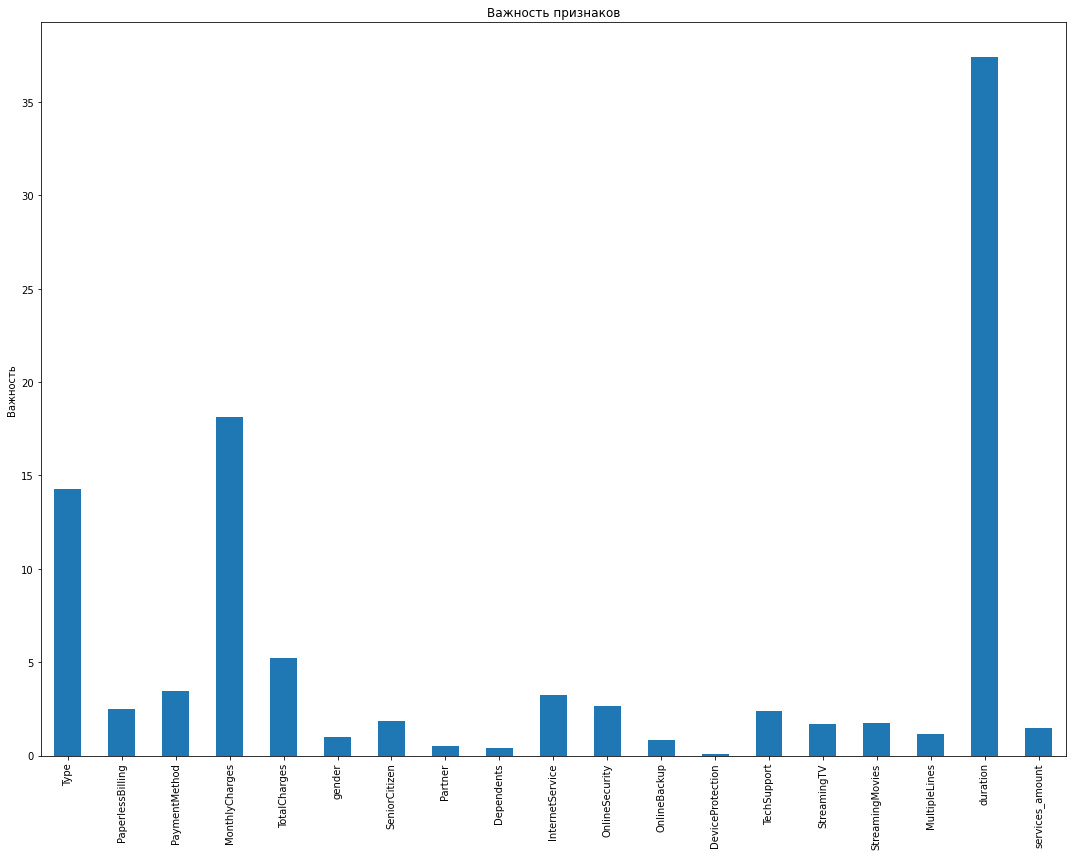

In [50]:
#Оценка важности признаков
cat_features = ['Type', 
                'PaperlessBilling', 
                'PaymentMethod', 
                'gender', 
                'SeniorCitizen', 
                'Partner', 
                'Dependents', 
                'InternetService',
                'OnlineSecurity',
                'OnlineBackup',
                'DeviceProtection',
                'TechSupport',
                'StreamingTV',
                'MultipleLines']

model_cb = CatBoostClassifier(loss_function="Logloss",
                           random_state=RANDOM_STATE, 
                           iterations=100)
model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=10)
cb_imp = pd.Series(model_cb.feature_importances_, features_train.columns)
fig, ax = plt.subplots(figsize=(15, 12))
cb_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

In [51]:
#то же самое, но в оцифрованном виде
model_cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,duration,37.393241
1,MonthlyCharges,18.145760
2,Type,14.295729
3,TotalCharges,5.206911
4,PaymentMethod,3.433668
5,InternetService,3.264629
6,OnlineSecurity,2.634519
7,PaperlessBilling,2.509980
8,TechSupport,2.379963
9,SeniorCitizen,1.835637


Для модели CatBoost достаточно всего четырех наиболее важных признаков.
Обучим модель, используя только эти признаки.

In [52]:
%%time

#отбор 4 самых важных признаков и подбор оптимальных гиперпараметров
features_imp_train = features_train[['MonthlyCharges', 
                                         'TotalCharges', 
                                         'duration',
                                         'Type']]

param_grid = [{
    'learning_rate': [0.03, 0.1],
    'depth': [1, 10],
    'l2_leaf_reg': [3, 5, 7, 9],
    'has_time': [True],
    'random_state': [RANDOM_STATE],
}]

model_cb = CatBoostClassifier(iterations=1000, loss_function="Logloss", class_weights = (3, 1), verbose=1000)

grid_search_cb = GridSearchCV(model_cb, param_grid, cv=5, scoring='roc_auc', n_jobs=1)
grid_search_cb.fit(features_imp_train, target_train, cat_features=['Type'])

roc_auc_cb = grid_search_cb.best_score_

print(f'roc_auc CatBoost: {roc_auc_cb}') 
print(f'Лучшие гиперпараметры: {grid_search_cb.best_params_}')

0:	learn: 0.6676297	total: 5.25ms	remaining: 5.24s
999:	learn: 0.2406874	total: 3.35s	remaining: 0us
0:	learn: 0.6677344	total: 1.39ms	remaining: 1.39s
999:	learn: 0.2452261	total: 3.19s	remaining: 0us
0:	learn: 0.6677934	total: 1.31ms	remaining: 1.31s
999:	learn: 0.2424592	total: 3.64s	remaining: 0us
0:	learn: 0.6677541	total: 1.53ms	remaining: 1.53s
999:	learn: 0.2438196	total: 3.79s	remaining: 0us
0:	learn: 0.6677340	total: 1.38ms	remaining: 1.38s
999:	learn: 0.2435287	total: 3.2s	remaining: 0us
0:	learn: 0.6123742	total: 1.38ms	remaining: 1.37s
999:	learn: 0.2314876	total: 3.27s	remaining: 0us
0:	learn: 0.6126941	total: 1.54ms	remaining: 1.53s
999:	learn: 0.2355184	total: 3.14s	remaining: 0us
0:	learn: 0.6128752	total: 1.36ms	remaining: 1.36s
999:	learn: 0.2329206	total: 3.34s	remaining: 0us
0:	learn: 0.6127291	total: 1.55ms	remaining: 1.54s
999:	learn: 0.2344477	total: 3.38s	remaining: 0us
0:	learn: 0.6126900	total: 1.33ms	remaining: 1.33s
999:	learn: 0.2333628	total: 3.16s	remain

Зафиксируем гиперпараметры лучшей модели, которые выдал GridSearch: {'depth': 10, 'has_time': True, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'random_state': 261222}

### Сравнение моделей

In [53]:
model_scores = [
        ['DecisionTree', score_tree],
        ['RandomForest', score_rf],
        ['LogisticRegression', score_lr],
        ['CatBoost', roc_auc_cb]
       ]
columns = ['model', 'ROC-AUC']

comparison = pd.DataFrame(data=model_scores, columns=columns)

comparison

,model,ROC-AUC
0,DecisionTree,0.839397
1,RandomForest,0.852371
2,LogisticRegression,0.846274
3,CatBoost,0.907261


C:\Users\Xiaomi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


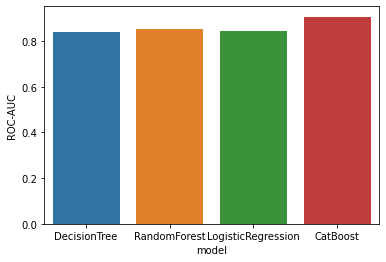

In [54]:
sns.barplot(comparison['model'], comparison['ROC-AUC']);

По результатам кросс-валидации модель CatBoost показала лучший результат по сравнению с более простыми моделями. Также ее преимущество в том, что для нее не нужно делать кодировку категориальных признаков, что упрощает дальнейшее использование модели. Выбираем ее для тестирования.

## Тестирование лучшей модели

In [55]:
#тестирование модели CatBoost
features_imp_test = features_test[['MonthlyCharges', 
                                         'TotalCharges', 
                                         'duration',
                                         'Type']]

model = CatBoostClassifier(loss_function="Logloss", 
                           depth=10, 
                           has_time=True, 
                           l2_leaf_reg=3, 
                           learning_rate=0.1,
                           random_state=RANDOM_STATE, 
                           class_weights = (3, 1),
                           iterations=1000)

model.fit(features_imp_train, target_train, cat_features=['Type'], verbose=100)

probabilities_test = model.predict_proba(features_imp_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_cb = roc_auc_score(target_test, probabilities_one_test)
accuracy_cb = accuracy_score(target_test, model.predict(features_imp_test))

print()
print('ROC-AUC', roc_auc_cb)
print('Accuracy', accuracy_cb)

0:	learn: 0.5787181	total: 39.4ms	remaining: 39.3s
100:	learn: 0.2061127	total: 2.49s	remaining: 22.2s
200:	learn: 0.1637197	total: 6.04s	remaining: 24s
300:	learn: 0.1356192	total: 9.57s	remaining: 22.2s
400:	learn: 0.1170140	total: 12.9s	remaining: 19.3s
500:	learn: 0.1043934	total: 16.3s	remaining: 16.3s
600:	learn: 0.0931480	total: 20.2s	remaining: 13.4s
700:	learn: 0.0852403	total: 23.6s	remaining: 10.1s
800:	learn: 0.0776789	total: 27s	remaining: 6.71s
900:	learn: 0.0718876	total: 30.3s	remaining: 3.33s
999:	learn: 0.0672546	total: 34s	remaining: 0us

ROC-AUC 0.9192302473283049
Accuracy 0.8682566723452584


Модель CatBoost с параметрами, подобранными алгоритмом GridSearch, демонстрирует высокие результаты на тестовой выборке в метриках ROC-AUC=0.92 и Accuracy=0.87.
Для дальнейшего использования рекомендуется именно эта модель с гиперпараметрами:

`loss_function="Logloss", 
depth=10, 
has_time=True, 
l2_leaf_reg=3, 
learning_rate=0.1,
random_state=RANDOM_STATE, 
iterations=1000`


## Отчет

В общих чертах проект выполнен по первоначально намеченному плану (п.1.2). Единственный невыполненный пункт - удаление признаков, которые слабо коррелируют с таргетом сразу после анализа корреляций. Решил удалять ненужные признаки позже, на основании анализа важности признаков для каждой модели, т.к. коэффициент корреляции необязательно говорит об отсутствии связи - она может быть нелинейной. Коэффициент phik, в отличие от корреляции Пирсона, показывает и на нелинейные связи, но даже он не идеален.

Сложнее всего было не запутаться в признаках и кодировках, т.к. для каких-то моделей нужна кодировка категориальных признаков, для других не нужна. Благо, признаков в датасете оказалось не так много, чтобы это стало серьезной проблемой.

После объединения таблиц и заполнения пропусков важно было изменить типы данных в столбцах, чтобы сделать их понятными для ML-алгоритмов. Например, в категориальных признаках со значениями Yes/No произведена замена на 1/0.

Ключом к выполнению проекта стало создание признака duration - длительности контракта, т.к. в итоге этот признак оказался наиболее важным для всех обученных моделей.

Было обучено 4 модели - DecisionTree, RandomForest, LogisticRegression и CatBoost. Поиск наилучших гиперпараметров произвел с помощью GridSearch, в результате на кросс-валидации были получены следующие результаты:

In [56]:
comparison

,model,ROC-AUC
0,DecisionTree,0.839397
1,RandomForest,0.852371
2,LogisticRegression,0.846274
3,CatBoost,0.907261


C:\Users\Xiaomi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


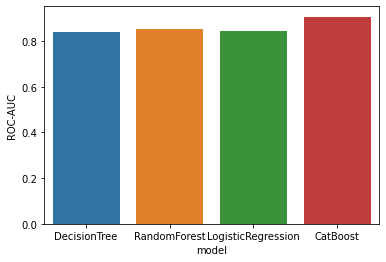

In [57]:
sns.barplot(comparison['model'], comparison['ROC-AUC']);

Все модели прошли целевой порог - минимум 0.75 по метрике ROC-AUC.
Для тестирования выбрана лучшая модель - CatBoost с гиперпараметрами:

`
loss_function="Logloss", 
depth=10, 
has_time=True, 
l2_leaf_reg=3, 
learning_rate=0.1,
random_state=RANDOM_STATE, 
class_weights = (3, 1),
iterations=1000
`

Метод feature_importances_ показал, что для качественного обучения модели достаточно всего 4 признаков:

['MonthlyCharges', 'TotalCharges', 'duration', 'Type']

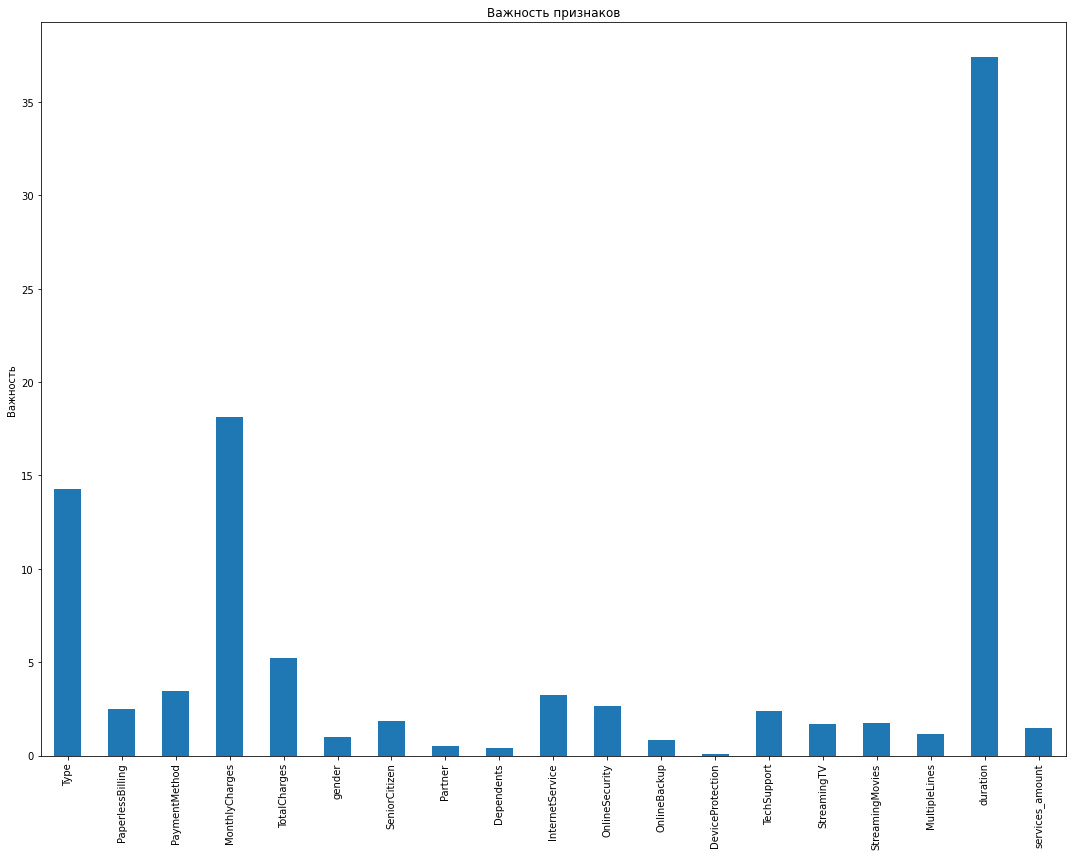

In [58]:
fig, ax = plt.subplots(figsize=(15, 12))
cb_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

На тестовой выборке метрика ROC-AUC у выбранной модели составила 0.92, точность Accuracy=0.87, что подтвердило высокое качество предсказаний.